# DCF model with web scraping for data

We will import all the python packages, scrape yahoo finance for financial information on a company, then input that data into a monte carlo DCF model that will compute a normal distribution of the fair value price of thew company.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t
import yfinance as yf
from lxml import html
import requests
import json
import argparse
from collections import OrderedDict
%matplotlib inline

**Note:** Can use Yahoo finance library yfinance for additional company data, but not for financials as the python package is not functioning properly and returns an empty array.

In [18]:
def get_page(url):
    # Set up the request headers that we're going to use, to simulate
    # a request by the Chrome browser. Simulating a request from a browser
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Pragma': 'no-cache',
        'Referrer': 'https://google.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'
    }

    return requests.get(url, headers=headers)

def parse_rows(table_rows):
    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append(np.NaN)
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
            
    return pd.DataFrame(parsed_rows)

def clean_data(df):
    df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
    df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
    
    # Rename the "Breakdown" column to "Date"
    cols = list(df.columns)
    cols[0] = 'Date'
    df = df.set_axis(cols, axis='columns', inplace=False)
    
    numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Date' column)

    for column_index in range(1, len(df.columns)): # Take all columns, except the first (which is the 'Date' column)
        df.iloc[:,column_index] = df.iloc[:,column_index].str.replace(',', '') # Remove the thousands separator
        df.iloc[:,column_index] = df.iloc[:,column_index].astype(np.float64) # Convert the column to float64
        
    return df

def scrape_table(url):
    # Fetch the page that we're going to parse
    page = get_page(url);

    # Parse the page with LXML, so that we can start doing some XPATH queries
    # to extract the data that we want
    tree = html.fromstring(page.content)

    # Fetch all div elements which have class 'D(tbr)'
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]")
    
    # Ensure that some table rows are found; if none are found, then it's possible
    # that Yahoo Finance has changed their page layout, or have detected
    # that you're scraping the page.
    assert len(table_rows) > 0
    
    df = parse_rows(table_rows)
    df = clean_data(df)
        
    return df

In [19]:
# choose a ticker symbol
symbol = 'MSFT'

In [20]:
#scrape balance sheet
bal=scrape_table('https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol)
print(bal)


,Date,Total Assets,Total Liabilities Net Minority Interest,Total Equity Gross Minority Interest,Total Capitalization,Common Stock Equity,Capital Lease Obligations,Net Tangible Assets,Working Capital,Invested Capital,Tangible Book Value,Total Debt,Net Debt,Share Issued,Ordinary Shares Number
1,6/30/2020,301311000.0,183007000.0,118304000.0,177882000.0,118304000.0,7671000.0,67915000.0,109605000.0,181631000.0,67915000.0,70998000.0,49751000.0,7571000.0,7571000.0
2,6/30/2019,286556000.0,184226000.0,102330000.0,168992000.0,102330000.0,6188000.0,52554000.0,106132000.0,174508000.0,52554000.0,78366000.0,60822000.0,7643000.0,7643000.0
3,6/30/2018,258848000.0,176130000.0,82718000.0,154960000.0,82718000.0,5568000.0,38982000.0,111174000.0,158958000.0,38982000.0,81808000.0,64294000.0,7677000.0,7677000.0
4,6/30/2017,241086000.0,168692000.0,72394000.0,148467000.0,72394000.0,NaN,27166000.0,95324000.0,158588000.0,27166000.0,86194000.0,78531000.0,7708000.0,7708000.0


In [21]:
#scrape the financial statements
fin=scrape_table('https://finance.yahoo.com/quote/' + symbol + '/financials?p=' + symbol)
print(fin)


,Date,Total Revenue,Cost of Revenue,Gross Profit,Operating Expense,Operating Income,Net Non Operating Interest Income Expense,Other Income Expense,Pretax Income,Tax Provision,...,Net Interest Income,EBIT,Reconciled Cost of Revenue,Reconciled Depreciation,Net Income from Continuing Operation Net Minority Interest,Total Unusual Items Excluding Goodwill,Total Unusual Items,Normalized EBITDA,Tax Rate for Calcs,Tax Effect of Unusual Items
1,ttm,153284000.0,48510000.0,104774000.0,44619000.0,60155000.0,-2757000.0,3328000.0,60726000.0,9416000.0,...,-2757000.0,63186000.0,48510000.0,12028000.0,51310000.0,3261000.0,3261000.0,71953000.0,0.0,505641.0
2,6/30/2020,143015000.0,46078000.0,96937000.0,43978000.0,52959000.0,-2591000.0,2668000.0,53036000.0,8755000.0,...,-2591000.0,55627000.0,46078000.0,12796000.0,44281000.0,2708000.0,2708000.0,65715000.0,0.0,446820.0
3,6/30/2019,125843000.0,42910000.0,82933000.0,39974000.0,42959000.0,-2686000.0,3415000.0,43688000.0,4448000.0,...,-2686000.0,46374000.0,42910000.0,11682000.0,39240000.0,3472000.0,3472000.0,54584000.0,0.0,354144.0
4,6/30/2018,110360000.0,38353000.0,72007000.0,36949000.0,35058000.0,-2733000.0,4149000.0,36474000.0,19903000.0,...,-2733000.0,39207000.0,38353000.0,10261000.0,16571000.0,4208000.0,4208000.0,45260000.0,0.0,1136160.0
5,6/30/2017,89950000.0,34261000.0,55689000.0,33057000.0,22632000.0,-2222000.0,2739000.0,23149000.0,1945000.0,...,-2222000.0,25371000.0,34261000.0,8778000.0,21204000.0,2990000.0,2990000.0,31159000.0,0.0,239200.0


In [22]:
#scrape cash flow
cash=scrape_table('https://finance.yahoo.com/quote/' + symbol + '/cash-flow?p=' + symbol)
print(cash)


,Date,Operating Cash Flow,Investing Cash Flow,Financing Cash Flow,End Cash Position,Capital Expenditure,Issuance of Capital Stock,Issuance of Debt,Repayment of Debt,Repurchase of Capital Stock,Free Cash Flow
1,ttm,68028000.0,-11451000.0,-50830000.0,14611000.0,-17592000.0,1529000.0,NaN,-6250000.0,-26128000.0,50436000.0
2,6/30/2020,60675000.0,-12223000.0,-46031000.0,13576000.0,-15441000.0,1343000.0,0.0,-5518000.0,-22968000.0,45234000.0
3,6/30/2019,52185000.0,-15773000.0,-36887000.0,11356000.0,-13925000.0,1142000.0,0.0,-4000000.0,-19543000.0,38260000.0
4,6/30/2018,43884000.0,-6061000.0,-33590000.0,11946000.0,-11632000.0,1002000.0,7183000.0,-10060000.0,-10721000.0,32252000.0
5,6/30/2017,39507000.0,-46781000.0,8408000.0,7663000.0,-8129000.0,772000.0,44344000.0,-7922000.0,-11788000.0,31378000.0


**Comment out box if would like to export data into excel**

In [ ]:
# export to excel
# date = datetime.today().strftime('%Y-%m-%d')
# writer = pd.ExcelWriter('Yahoo-Finance-Scrape-' + date + symbol + '.xlsx')
# df_combined.to_excel(writer)
# writer.save()

In [ ]:
capex=cash.capex[0]
EBIT=fin.EBIT[0]
sales=fin.Total Revenue[0]
prior_sales=(sales[1]+sales[2])/2
sales_pct=(sales[0]/prior_sales)*100
Taxes=
Amort=
DEP=fin.Reconciled Depreciation[0]
non_cwc=0
fcf=cash.loc('Free Cash Flow')
fcf=fcf[0]
UFCF=EBIT-Taxes+DEP+Amort-Capex-non_cwc

In [26]:
# Key inputs from DCF model
years = 5
starting_sales = 80.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.21
# DCF assumptions
r = 0.12
g = 0.02
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

In [27]:
def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, scale=sales_std_dev, size=(years, iterations))
    
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, scale=ebitda_std_dev, size=(years, iterations))
    
    nwc_percent_dist = np.random.normal(loc=nwc_percent, scale=nwc_std_dev, size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
        
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,6)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

Wall time: 54 ms


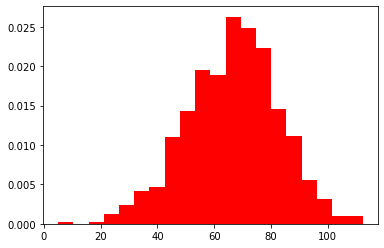

In [28]:
%time plt.hist(run_mcs(), bins=20, density=True, color="r")
plt.show()